# Build static PPI network of budding yeast cell cycle from KEGG

Here, we convert the cell cycle network from KEGG to a static protein-protein interaction (PPI) network.  

The KEGG network is available as an .xml file for entry sce04111 at: 
https://www.genome.jp/kegg-bin/show_pathway?sce04111  

We merge duplicate nodes, and deal with different types of KEGG nodes, among other things.

In [1]:
import xml.etree.cElementTree as ET

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sb

sb.set_context("paper")

In [2]:
def rm_dots(name):
    """Remove dot in node name"""
    return name.split(".")[0]


def shorten_name(name):
    """Shorten long node names"""
    return name.split(",")[0]

## 1.0 Load and parse Kegg network file

In [3]:
kegg_filepath = "../data/kegg/sce04111.xml"

tree = ET.parse(kegg_filepath)  # parse xml structure

The KEGG network is stored as nodes ("entry") and edges ("relation").  
There are different types of nodes.

#### Explore node data

In [4]:
types = []
for entry in tree.iter("entry"):  # loop over nodes # getiterator: deprecated
    node_type = entry.get("type")
    types.append(node_type)

print("Node types and their respective counts:")
print(np.unique(types, return_counts=True))

# node type examples
# 'map' : MPAK signaling pathway
# 'ortholog': id '132','name': 'K18679'
# 'group' : multi-node boxes

Node types and their respective counts:
(array(['compound', 'gene', 'group', 'map', 'ortholog'], dtype='<U8'), array([  2, 125,  27,   4,   3]))


In [5]:
print(f"There are {len(types)} kegg nodes in total")

There are 161 kegg nodes in total


In [6]:
# inspect nodes that are not gene or group
for entry in tree.iter("entry"):
    type_ = entry.get("type")
    if type_ in ["compound", "map", "ortholog"]:
        print(type_, entry.get("name"))

compound cpd:C00575
compound cpd:C00009
map path:sce04120
map path:map04020
map path:map04010
map path:sce04111
ortholog ko:K18679
ortholog ko:K18680
ortholog ko:K18669


## 1. Extract all Kegg nodes

In [7]:
# store raw Kegg data in dictionary

kegg_nodes = {}  # collect all nodes with id, name, and type

for entry in tree.iter("entry"):  # loop over nodes

    node_id = entry.get("id")  # integer
    node_type = entry.get("type")

    graphics = entry.find("graphics")
    node_name = graphics.get("name")  # protein or complex name

    kegg_nodes[node_id] = {"name": node_name, "type": node_type}

## 2. Extract Kegg gene nodes

In [8]:
gene_nodes = {
    node: attr for node, attr in kegg_nodes.items() if attr["type"] == "gene"
}  # gene node dict by kegg id

print(len(gene_nodes), "kegg gene node ids")

125 kegg gene node ids


In [9]:
# remove duplicate nodes
gene_node_names = [
    attr["name"] for node, attr in gene_nodes.items()
]  # list of gene node names

gn, cnts = np.unique(gene_node_names, return_counts=True)
print("duplicates :", gn[cnts > 1])
print("# appearances :", cnts[cnts > 1])

gene_node_names = sorted(list(set(gene_node_names)))
print()
print(len(gene_node_names), "unique kegg gene nodes (raw)")

duplicates : ['BUB3, PAC9' 'CDC20, PAC5' 'CDC27, APC3, SNB1...'
 'CDC28, CDK1, HSL5, SRM5' 'CDC5, MSD2, PKX2' 'CDC53...' 'MAD2' 'MAD3'
 'PHO85, LDB15' 'SIC1, BYC1, SDB25' 'SWI6, PSL8, SDS11']
# appearances : [3 4 3 5 2 3 2 2 2 2 2]

106 unique kegg gene nodes (raw)


In [10]:
# reduce length of composed names

gene_nodes_long = {}  # collect names that are shortened

for node, attr in gene_nodes.items():

    name = attr["name"]
    if "," in name:
        #         print(name)
        name_new = shorten_name(name)
        gene_nodes[node]["name"] = name_new  # set new short name
        gene_nodes_long[node] = name  # store changed names

    # by this, "ORC2, RRR1, SIR5" and "ORC2, RRR1, SIR5..." are merged
    # (all others have a different first name)

print(len(gene_nodes), "kegg gene node ids")

# do same for name list
for i, name in enumerate(gene_node_names):
    if "," in name:
        #         print(name)
        name_new = shorten_name(name)
        gene_node_names[i] = name_new

gene_node_names = sorted(list(set(gene_node_names)))
print(
    len(gene_node_names),
    "unique kegg gene nodes (after shortening long names)",
)

125 kegg gene node ids
105 unique kegg gene nodes (after shortening long names)


In [11]:
# remove dots in names

# gene_names_dotted = [name for name in gene_node_names if ".." in name]

gene_names_dotted = []

for i, name in enumerate(gene_node_names):

    if ".." in name:

        name_new = rm_dots(name)
        if name_new in gene_node_names:
            print(name, "new duplicate, non-dotted counterpart already exists")
        gene_node_names[i] = name_new

        gene_names_dotted.append(name)  # store affected names

print(len(gene_names_dotted), "gene names with dots")

# do the same for gene_nodes dict (will be used later to centralise)

for node, attr in gene_nodes.items():

    name = attr["name"]
    if ".." in name:
        #         print(name)
        name_new = rm_dots(name)
        gene_nodes[node]["name"] = name_new  # set new short name

# recheck for duplicates and keep unique names

gn, cnts = np.unique(gene_node_names, return_counts=True)
print("duplicates :", gn[cnts > 1])
print("# appearances :", cnts[cnts > 1])

gene_node_names = sorted(list(set(gene_node_names)))
print()
print(
    len(gene_node_names),
    "unique kegg gene nodes (after removing dotted duplicates)",
)

MCM2... new duplicate, non-dotted counterpart already exists
8 gene names with dots
duplicates : ['MCM2']
# appearances : [2]

104 unique kegg gene nodes (after removing dotted duplicates)


In [12]:
# replace those specific names

names_to_replace = {
    "CDC27": "APC",
    "CDC53": "SCF",
    "TPD3": "PP2A",
    "ORC2": "ORC",
    "MCM2": "MCM",
    "LCD1": "DDC2",
}

for name, name_new in names_to_replace.items():

    if name in gene_node_names:
        idx = gene_node_names.index(name)
        gene_node_names[idx] = name_new

    # do the same for gene_nodes dict (will be used later to centralise)

    for node, attr in gene_nodes.items():

        if name == attr["name"]:
            #         print(name)
            gene_nodes[node]["name"] = name_new  # set new short name

gene_node_names = sorted(list(set(gene_node_names)))
print(
    len(gene_node_names),
    "unique kegg gene nodes (after replacing specific names)",
)

104 unique kegg gene nodes (after replacing specific names)


In [13]:
# remove those disconnected nodes

MCMs = [f"MCM{i}" for i in [3, 4, 5, 6, 7]]
ORCs = [f"ORC{i}" for i in [1, 3, 4, 5, 6]]

# PHOs = ['PHO2', 'PHO4', 'PHO80', 'PHO81', 'PHO85', 'PCL2', 'PHO11...']
Condensin = ["SMC2", "SMC4", "YCS4", "BRN1", "YCG1"]
lost = ["DAM1", "SCC2", "SCC4"]

nodes_to_rm = MCMs + ORCs + Condensin + lost

for node in nodes_to_rm:

    # in dict
    for id_, attr in list(gene_nodes.items()):
        if attr["name"] == node:
            del gene_nodes[id_]
            print(f"deleted {node}")
    # in list
    idx = gene_node_names.index(node)
    gene_node_names.pop(idx)

gene_node_names = sorted(list(set(gene_node_names)))
print(
    len(gene_node_names),
    f"unique kegg gene nodes (after removing {len(nodes_to_rm)} disconnected nodes)",
)

deleted MCM3
deleted MCM4
deleted MCM5
deleted MCM6
deleted MCM7
deleted ORC1
deleted ORC3
deleted ORC4
deleted ORC5
deleted ORC6
deleted SMC2
deleted SMC4
deleted YCS4
deleted BRN1
deleted YCG1
deleted DAM1
deleted SCC2
deleted SCC4
86 unique kegg gene nodes (after removing 18 disconnected nodes)


In [14]:
# gene_node_names
# check that this list is correct !

## 3. Extract KEGG group nodes

Kegg 'group' nodes are are composed of 'gene' nodes, their 'components'. 

In [15]:
group_nodes = {}  # dict of kegg group nodes by id, with components and name

gene_nodes_in_group = {}  # dict of gene nodes by id, with id of group they belong to

for entry in tree.iter("entry"):

    if entry.get("type") == "group":  # loop over group nodes

        group_id = entry.get("id")

        group = []  # list of components in group

        for component in entry.iter("component"):  # create list of components

            component_id = component.get("id")
            group.append(
                gene_nodes[component_id]["name"]
            )  # might not be cleaned name /!\
            gene_nodes_in_group[component_id] = {"group_id": group_id}

        group_name = ("-").join(group)

        group_nodes[group_id] = group

# match group node id to true group name
true_groups = {"152": "Cohesin"}
#                '137' : 'SBF',
#               '138' : 'MBF',
#               '148' : 'MCC',
#              }

## 4. Extract all Kegg relations

In [16]:
kegg_relations = {}

# parse edges from relations
for rel in tree.iter("relation"):
    e1 = rel.get("entry1")
    e2 = rel.get("entry2")

    type1 = kegg_nodes[e1]["type"]
    type2 = kegg_nodes[e2]["type"]

    es = [e1, e2]
    types = [type1, type2]
    names = [None, None]

    # get best name for id (best is gene_nodes, then true groups, then least clean is kegg_nodes)
    for i, type_ in enumerate(types):
        if type_ == "gene":
            names[i] = gene_nodes[es[i]]["name"]
        elif type_ == "group":
            if es[i] in true_groups.keys():
                names[i] = true_groups[es[i]]
            else:
                names[i] = kegg_nodes[es[i]]["name"]
        else:
            print(f"relation without gene or group node : {e1, e2, type1, type2}")

    kegg_relations[f"{e1}-{e2}"] = {
        "pair": (e1, e2),
        "names": tuple(names),
        "types": tuple(types),
    }

relation without gene or group node : ('36', '7', 'gene', 'compound')


In [17]:
# visualise
df_kegg_relations = pd.DataFrame.from_dict(kegg_relations, orient="index")
df_kegg_relations[df_kegg_relations["types"] == ("gene", "group")]

pair            names          types
49-135    (49, 135)     (FAR1, None)  (gene, group)
40-136    (40, 136)     (SIC1, None)  (gene, group)
36-140    (36, 140)    (PHO81, None)  (gene, group)
55-137    (55, 137)     (WHI5, None)  (gene, group)
55-138    (55, 138)     (WHI5, None)  (gene, group)
128-147  (128, 147)     (MAD1, None)  (gene, group)
58-152    (58, 152)  (ESP1, Cohesin)  (gene, group)
62-153    (62, 153)    (SLK19, None)  (gene, group)
118-154  (118, 154)     (CDC5, None)  (gene, group)
89-157    (89, 157)     (SIC1, None)  (gene, group)
92-157    (92, 157)     (SWE1, None)  (gene, group)
96-157    (96, 157)     (CAK1, None)  (gene, group)

In [18]:
# count types of relations
n_gege = len(df_kegg_relations[df_kegg_relations["types"] == ("gene", "gene")])
n_grge = len(df_kegg_relations[df_kegg_relations["types"] == ("group", "gene")]) + len(
    df_kegg_relations[df_kegg_relations["types"] == ("gene", "group")]
)
n_grgr = len(df_kegg_relations[df_kegg_relations["types"] == ("group", "group")])

print(f"# gene-gene: {n_gege}, # group-gene: {n_grge}, # group-group: {n_grgr}")

# gene-gene: 36, # group-gene: 47, # group-group: 4


## 5. Generate static network edges 

### 5.1 extract from kegg relations

Types of links from relations between KEGG objects:
- gene-gene
- gene-group
- group-group
- inter-group

In [19]:
def is_in_group(node_id):
    """Return True if (gene) node is in a group node"""
    return node_id in gene_nodes_in_group.keys()


def is_true_group(group_id):
    """Return True if group node is a true group"""
    return group_id in true_groups.keys()


def is_in_true_group(node_id):
    """Return True if (gene) node is in a true group node"""
    if is_in_group(node_id):
        group_id = gene_nodes_in_group[node_id]["group_id"]
        return is_true_group(group_id)
    else:
        return False

In [20]:
edges_dict = {}  # dict of edges by pair of ids

for rel, rel_attr in kegg_relations.items():  # loop over all kegg relations

    rel_type = rel_attr["types"]
    id_1, id_2 = rel_attr["pair"]
    name_1, name_2 = rel_attr["names"]

    if rel_type == (
        "gene",
        "gene",
    ):  # ================================= gene-gene

        if (not is_in_true_group(id_1)) and (
            not is_in_true_group(id_2)
        ):  # no gene in true group

            edge = tuple(sorted([name_1, name_2]))
            edges_dict[edge] = rel_type  # add gene-gene link

        else:  # if gene in true group, add group-gene link
            if is_in_true_group(id_1) and (not is_in_true_group(id_2)):

                group_id_1 = gene_nodes_in_group[id_1]["group_id"]
                group_name_1 = true_groups[group_id_1]
                edge = tuple(sorted([group_name_1, name_2]))
                edges_dict[edge] = rel_type

            elif is_in_true_group(id_2) and (not is_in_true_group(id_1)):

                group_id_2 = gene_nodes_in_group[id_2]["group_id"]
                group_name_2 = true_groups[group_id_2]
                edge = tuple(sorted([name_1, group_name_2]))
                edges_dict[edge] = rel_type

            elif is_in_true_group(id_1) and is_in_true_group(id_2):

                group_id_1 = gene_nodes_in_group[id_1]["group_id"]
                group_name_1 = true_groups[group_id_1]
                group_id_2 = gene_nodes_in_group[id_2]["group_id"]
                group_name_2 = true_groups[group_id_2]
                edge = tuple(sorted([group_name_1, group_name_2]))
                edges_dict[edge] = rel_type
            else:
                print("error in gene-gene part")

    elif rel_type == (
        "group",
        "gene",
    ):  # ============================== group-gene

        if is_true_group(id_1):  # add group-gene edge

            group_name_1 = true_groups[id_1]

            if is_in_true_group(id_2):
                group_id_2 = gene_nodes_in_group[id_2]["group_id"]
                group_name_2 = true_groups[group_id_2]
                edge = tuple(sorted([group_name_1, group_name_2]))
                edges_dict[edge] = rel_type

            else:

                edge = tuple(sorted([group_name_1, name_2]))
                edges_dict[edge] = rel_type

        else:  # add link between each gene in group and external gene

            group_components = group_nodes[id_1]

            for comp in group_components:

                if is_in_true_group(id_2):
                    group_id_2 = gene_nodes_in_group[id_2]["group_id"]
                    group_name_2 = true_groups[group_id_2]
                    edge = tuple(sorted([comp, group_name_2]))
                    edges_dict[edge] = rel_type
                else:
                    edge = tuple(sorted([comp, name_2]))
                    edges_dict[edge] = rel_type

    elif rel_type == (
        "gene",
        "group",
    ):  # ============================== gene-group

        if is_true_group(id_2):  # add group-gene edge

            group_name_2 = true_groups[id_2]

            if is_in_true_group(id_1):
                group_id_1 = gene_nodes_in_group[id_1]["group_id"]
                group_name_1 = true_groups[group_id_1]
                edge = tuple(sorted([group_name_1, group_name_2]))
                edges_dict[edge] = rel_type

            else:

                edge = tuple(sorted([name_1, group_name_2]))
                edges_dict[edge] = rel_type

        else:  # add link between each gene in group and external gene

            group_components = group_nodes[id_2]

            for comp in group_components:

                if is_in_true_group(id_1):
                    group_id_1 = gene_nodes_in_group[id_1]["group_id"]
                    group_name_1 = true_groups[group_id_1]
                    edge = tuple(sorted([comp, group_name_1]))
                    edges_dict[edge] = rel_type
                else:
                    edge = tuple(sorted([comp, name_1]))
                    edges_dict[edge] = rel_type

    elif rel_type == (
        "group",
        "group",
    ):  # ============================== group-group

        if is_true_group(id_1) and is_true_group(id_2):  # add group-group edge

            edge = tuple(sorted([true_groups[id_1], true_groups[id_2]]))
            edges_dict[edge] = rel_type

        elif is_true_group(id_1) and (not is_true_group(id_2)):
            # add link between each gene in group and external gene
            group_components = group_nodes[id_2]

            for comp in group_components:
                edge = tuple(sorted([comp, name_1]))
                edges_dict[edge] = rel_type

        elif (not is_true_group(id_1)) and is_true_group(id_2):
            # add link between each gene in group and external gene
            group_components = group_nodes[id_1]

            for comp in group_components:
                edge = tuple(sorted([comp, name_2]))
                edges_dict[edge] = rel_type

        elif (not is_true_group(id_1)) and (not is_true_group(id_2)):
            # add link between each gene in two different groups
            group_components_1 = group_nodes[id_1]
            group_components_2 = group_nodes[id_2]

            for comp_1 in group_components_1:
                for comp_2 in group_components_2:

                    edge = tuple(sorted([comp_1, comp_2]))
                    edges_dict[edge] = rel_type

In [21]:
print(f"{len(edges_dict)} edges")

140 edges


### 5.2 Add intra-group links

In [22]:
for group_id, components in group_nodes.items():

    if is_true_group(group_id):
        pass
    else:
        n_comp = len(components)

        for i in range(n_comp):
            for j in range(i):

                edge = tuple(sorted([components[i], components[j]]))
                edges_dict[edge] = "inter-group"

In [23]:
print(f"{len(edges_dict)} edges")

162 edges


In [24]:
# remove gene nodes from true groups (cannot be done before, could miss links)

Cohesin = ["SMC1", "SMC3", "MCD1", "IRR1"]

nodes_to_rm = Cohesin

for node in nodes_to_rm:

    # in dict
    for id_, attr in list(gene_nodes.items()):
        if attr["name"] == node:
            del gene_nodes[id_]
            print(f"deleted {node}")
    # in list
    idx = gene_node_names.index(node)
    gene_node_names.pop(idx)

gene_node_names = sorted(list(set(gene_node_names)))
print(
    len(gene_node_names),
    f"unique kegg gene nodes (after removing {len(nodes_to_rm)} true groups disconnected nodes)",
)

deleted SMC1
deleted SMC3
deleted MCD1
deleted IRR1
82 unique kegg gene nodes (after removing 4 true groups disconnected nodes)


In [25]:
# remove self-edges added by group-gene links with MCC

for pair, attr in list(edges_dict.items()):
    e1, e2 = pair
    if e1 == e2:
        del edges_dict[pair]
        print("deleted", pair)

deleted ('MAD2', 'MAD2')
deleted ('CDC20', 'CDC20')
deleted ('MAD3', 'MAD3')
deleted ('BUB3', 'BUB3')


In [26]:
# add CLB3 CDC28 edge

edges_dict[("CDC28", "CLB3")] = "inter-group"

## 6. Build static PPI network 

In [27]:
nodes_net = gene_node_names + list(true_groups.values())
nodes_net = sorted(nodes_net)

edges_net = sorted(list(edges_dict.keys()))

In [28]:
print(f"{len(nodes_net)} nodes and {len(edges_net)} edges")

83 nodes and 159 edges


In [29]:
# create networkx network
G = nx.Graph()

G.add_nodes_from(nodes_net)
G.add_edges_from(edges_net)

print(len(G), "nodes")
print(len(G.edges), "edges")

83 nodes
159 edges


In [30]:
# save network
outdir = "../data/kegg"
nx.write_edgelist(G, f"{outdir}/static_PPI_network_KEGG.edgelist")
nx.write_adjlist(G, f"{outdir}/static_PPI_network_KEGG.adjlist")  # labels are lost here

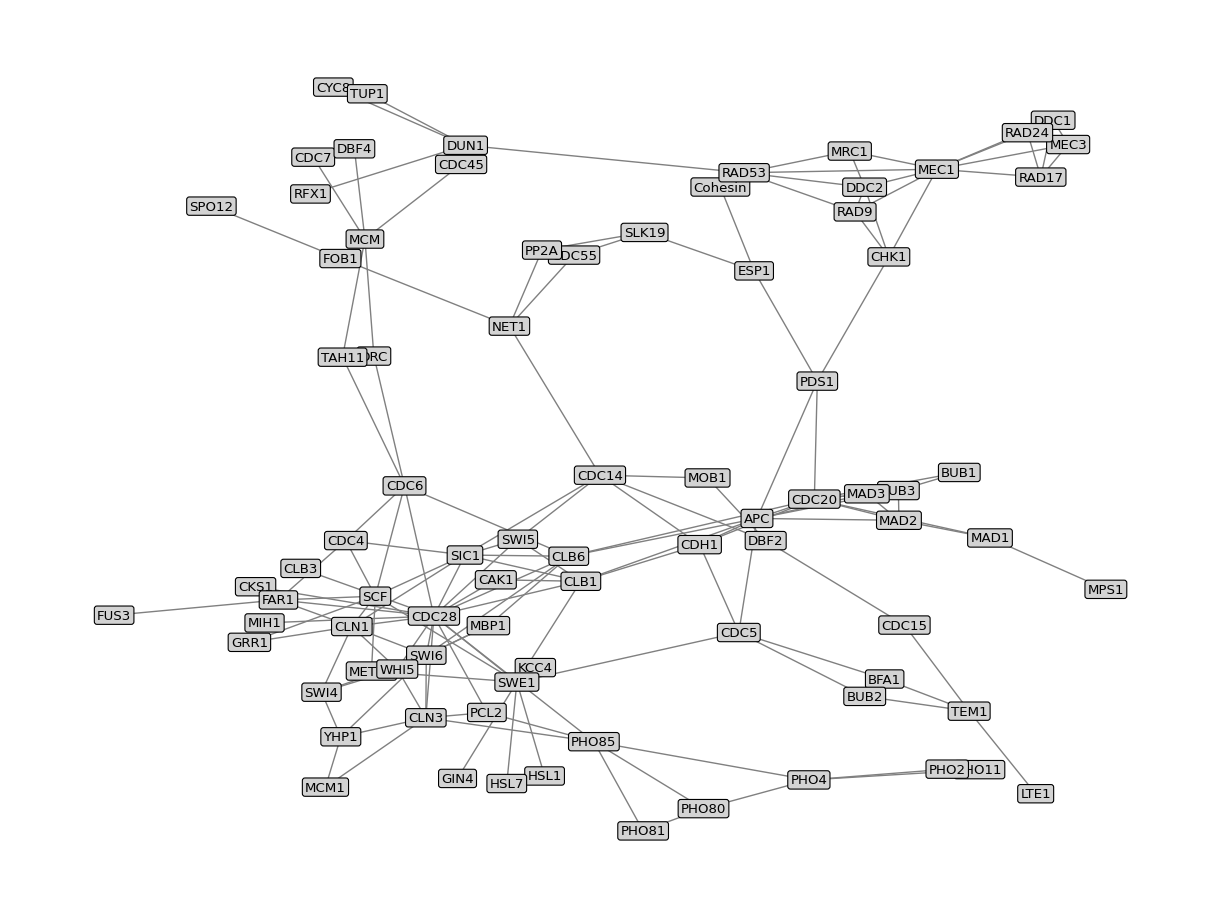

In [44]:
# draw network

plt.figure(figsize=(12, 9))

# pos = graphviz_layout(G, prog="neato")
pos = nx.spring_layout(G, k=0.2)

params = {
    "with_labels": True,
    "node_color": "white",
    "node_size": 100,
    "edge_color": "grey",
    "font_color": "k",
    "font_size": "medium",
    "bbox": dict(facecolor="lightgrey", edgecolor="black", boxstyle="round, pad=0.2"),
}

nx.draw(G, pos=pos, **params)

fig_dir = "images/kegg/"

# plt.savefig(f"{fig_dir}cell_cycle_static_PPI_network.png", dpi=300, bbox_inches="tight")
# plt.savefig(f"{fig_dir}cell_cycle_static_PPI_network.svg", dpi=300, bbox_inches="tight")

plt.show()